# Load, Filter Data

In [11]:
import pandas as pd
import os 
import json
import matplotlib.pyplot as plt


data = "articles/"


def read_to_list(filepath):
    with open(filepath,'r') as f:
        return list(json.load(f).values())

def get_articles_df(root):
    article_filepaths = [os.path.join(root,fn) for fn in os.listdir(root)]
    articles = [read_to_list(fp) for fp in article_filepaths]
    df = pd.DataFrame(articles)
    df.columns = ["link", "text","authorship", "date"]
    
    
    expanded_link_df=  df['link'].str.rsplit('/',n=0,expand=True)
    # links look like this https://www.respekt.cz/tydenik/1993/17/zadne-zimmer-frei?issueId=217
    df['year'] = expanded_link_df[4]
    df['issue_num'] = expanded_link_df[5]
    
    link_series = expanded_link_df[6].str.split('?',n=1,expand=True)
    df['name'] = link_series[0]
    
    return df




def filter_authors(df):
    df = df[df['authorship']!='Respekt']
    return df[df['authorship']!='']


def filter_categories(df):    
    # preaching in these categories may not be relevant
    names_blacklist = [
        'anketa',
        'televize',
        'dopisy',
        'styl',
        'zen-zen',
        'pripravujeme',
        'respekt-despekt',
        'hudba',
        'knihy',
        'vystavy',
        'divadlo',
        'jeden-den-v-zivote']
    
    return df[~df["name"].isin(names_blacklist)]

def filter_empty(df)    :
    return df[df['text']!='']

def filter_articles(df):
    filtered = filter_empty(df)
    filtered = filter_authors(filtered)
    filtered = filter_categories(filtered)
    # ...
    return filtered


# Article per Year

Filtered articles are not part of the calculation

<BarContainer object of 33 artists>

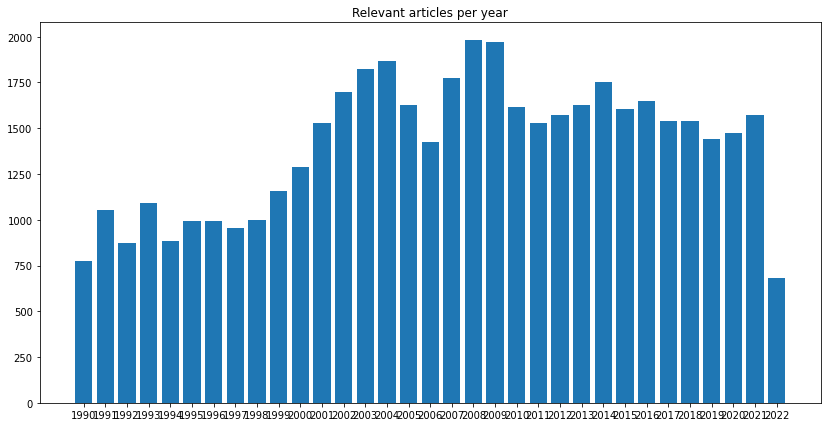

In [14]:
df = get_articles_df(data)
filtered = filter_articles(df)

article_counts = filtered[['year','link']].groupby('year').count().rename(columns={'link':'article_count'}).reset_index()
plt.figure(figsize=(14,7))
plt.title("Relevant articles per year") #those that were not filtered out
plt.bar(article_counts['year'],article_counts['article_count'])

# Analysis

Core of the analysis is identificaiton of "should" sentences - sentences that contain "měl by" and its alternatives. I used simple algorithm (see `get_should_sentences`) which does the following:
- Split text into sentences
- Filters out questions as they are likely irrelevant
- Split sentences to clauses
- Filter out clauses starting with kdo, co, jak, koho, jako by
- Calculate number of clauses with words "měl" and "by" and its other forms.

Example:

In [22]:
texts = filtered[filtered['authorship']=='Jan Macháček, Zbyněk Petráček, Bohuslav Blažek, Tomáš Pěkný']['text'].values.tolist()

for text in texts:
    should_sentences =get_should_sentences(text)
    for i,should_sentence in enumerate( should_sentences):
        print(i+1,'\t',should_sentence.strip())

1 	 tam by měly být nové emisní limity pro závody a také velmi tvrdé sankce
2 	 když se odstaví jednotlivé zdroje: tím by se přece mělo začít
3 	 na to by měla pamatovat vláda v nových zákonech
4 	 hygienik by přece měl město tlačit k tomu
5 	 smogový štáb
při vzniku smogové situace a předpovědi jejího dalšího trvání by měla být vyhlašována regulační opatření
6 	 že by v tom měl hrát hlavní roli hygienik
7 	 první regulační mechanismus by podle mne měl zahrnovat osobní ochranu dětí
8 	 podle mé představy by měl mít každý občan jakéhosi svého tribuna pro životní prostředí
9 	 že by je měli dávat lékaři a hygienici
10 	 ten soubor „jak se chovati při zhoršených rozptylových situacích“ by měl vyjít od nás
11 	 tak školy v oblasti 1 nebudou smět vůbec cvičit a do mateřských školek v oblasti 3 by se asi vůbec neměly vodit děti
12 	 obecně ale platí: v zimním období by v praze měly být cvičební hodiny přes poledne
13 	 ministerstvo zdravotnictví by mělo určit
14 	 tento systém by se měl roze

In [16]:
def get_should_sentences(text:str):
    
    # hack with ?. to recognize questions
    sentences = text.replace("?",'?.').replace('!','.').lower().split('.')
    not_questions = [s for s in sentences if not s.endswith('?')]
    clauses = sum([ s.split(',') for s in not_questions],[])
    
    def begins_with_unwanted(c):
        unwanted = ['kdo','co','jak', 'koho', 'jako by']
        res= any( [ c.startswith(unwanted_word) for unwanted_word in unwanted] )
        return res
        
    clauses_wo_co_kdo = [ c for c in clauses if not begins_with_unwanted(c.strip())]
    
    return [ c for c in clauses_wo_co_kdo if  "měl" in c and "by" in c.replace(',',"").split()]

    
def get_should_count_from_text(text):
    # TODO
    
    should_sentences = get_should_sentences(text)
    return len(should_sentences)


def count_should_per_year(df):
    df['should_count'] = df['text'].apply(lambda x: get_should_count_from_text(x))

    return df[['year','should_count']].groupby(['year']).sum()

def count_articles_per_year(df):
    
    return df[['year','link']].groupby(['year']).count()
    
def count_should_per_author(df):
    df['should_count'] = df['text'].apply(lambda x: get_should_count_from_text(x))

    counts = df[['authorship','link']].groupby(['authorship']).count()
    sums = df[['authorship','should_count']].groupby(['authorship']).sum()

    sums['article_count'] = counts
    df = sums
    df["should_per_article"] = df['should_count']/df['article_count']

    return df.sort_values(by=['should_per_article'], ascending=False)

articles_per_year = count_articles_per_year(filtered)
should_per_year = count_should_per_year(filtered)
should_per_year['article_count']=articles_per_year['link']
should_per_year_per_issue = should_per_year['should_count'] / should_per_year['article_count']


<BarContainer object of 33 artists>

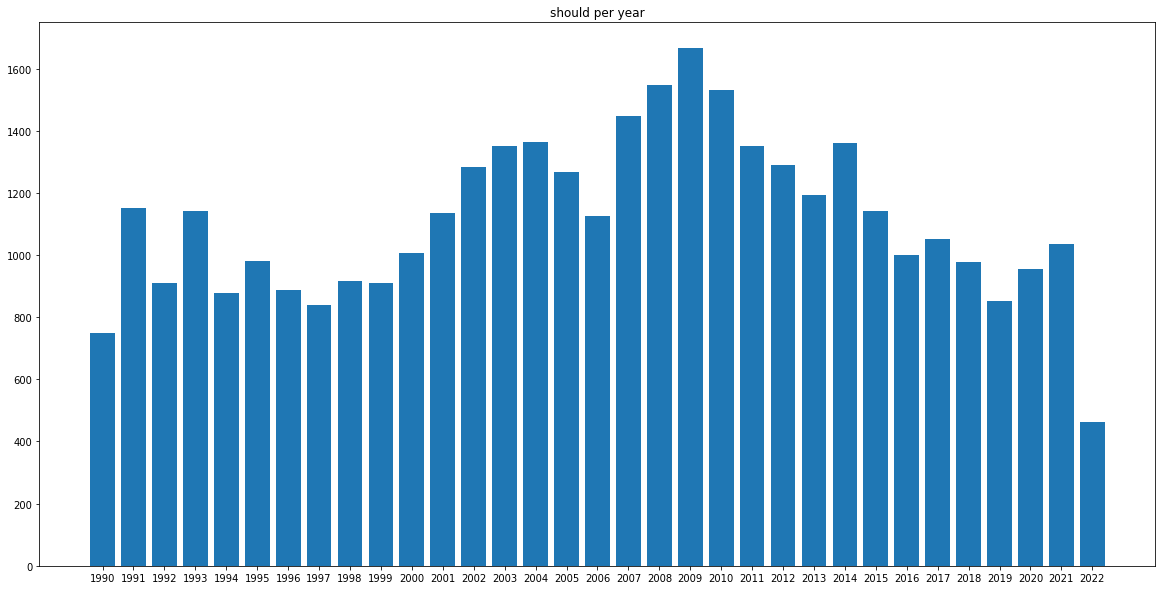

In [19]:
should_per_year = should_per_year.reset_index()
keys = should_per_year['year']
data =  should_per_year['should_count'].values
plt.figure(figsize=(20,10))
plt.title("should per year")
plt.bar(keys,data)

In [20]:
count_should_per_author(filtered)

,should_count,article_count,should_per_article
authorship,,,
"Maciej Szymanowski, Jiří Večerník",32,1,32.0
"Jan Macháček, Zbyněk Petráček, Bohuslav Blažek, Tomáš Pěkný",15,1,15.0
"Jaroslav Spurný, Martin Kontra a Jiří Chalupa",11,1,11.0
"Tomáš Pavlíček, Renate Zoeller",11,1,11.0
Erik Tabery a foto: Matěj Stránský,21,2,10.5
...,...,...,...
"Ondřej Kundra a foto: Matěj Stránský, Kodaň",0,1,0.0
Jaromír Levíček,0,3,0.0
Jaromír Kulíř,0,3,0.0


In [3]:
# def summarize_categories(df:pd.DataFrame):
#     name_counts = df[['name','link']].groupby(by='name').count()
#     name_groups = name_counts.sort_values('link')
    
#     return name_groups[name_groups['link']>1]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     categories = summarize_categories(df)
#     display(categories.sort_values(by='link',ascending=False))

,link
name,
dopisy,1319
minuly-tyden,947
respekt-despekt,682
pripravujeme,670
zen-zen,596
uplynulych-sedm-dni-ocima-ivana-lampera,501
editorial,373
pripomenme-si,300
deset-ceskych-zprav-ktere-by-vas-nemely-minout,299
